In [66]:
from pathlib import Path
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
import seaborn as sns

import trompy as tp

from scipy import stats
import statsmodels.api as sm

colors_PVH = "#219C90"
colors_VMH  = "#90219c"

colors = [colors_PVH, colors_VMH]

cmap = "RdBu_r"

In [67]:
DATAFOLDER = Path("C:/Data/hislight_pickles/")
FIGSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper/figures")
STATSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper")

with open(DATAFOLDER / "restricted_dark.pickle", 'rb') as handle:
    PVH = pickle.load(handle)

with open(DATAFOLDER / "HL3_restricted_dark.pickle", 'rb') as handle:
    VMH = pickle.load(handle)   

In [68]:
PVH_list_of_mice = []
VMH_list_of_mice = []

mice_to_exclude = ["HL313", "HL314", "HL315", "HL316", "HL317", "HL318", "HL306", "HL308",
                    "HL202", "HL205", "HL206", "HL211",
                    "HL301", "HL304", "HL305"]

#"HL202", "HL205", "HL206", "HL211" have poor placements without virus in PVH
#HL 306, 308 have no virus
#HL301, HL304, HL305 have poor fiber placement
#HL313 - HL318 are control mice


for key, val in PVH.items():
    if val["mouse_ID"] not in mice_to_exclude:
        if val["mouse_ID"] not in PVH_list_of_mice:
            PVH_list_of_mice.append(val["mouse_ID"])
        
for key, val in VMH.items():
    if val["mouse_ID"] not in mice_to_exclude:
        if val["mouse_ID"] not in VMH_list_of_mice:
            VMH_list_of_mice.append(val["mouse_ID"])

In [69]:
def get_aucs(data, mouse):
    
    pre = 5
    post = 10
    mineventlength = 8
    binlength = 0.1

    snips_full = []
    run_lengths = []

    for key, val in data.items():
        if val["mouse_ID"] == mouse:
            if len(val["licks"]) < 10:
                continue

            lickdata = tp.lickCalc(val["licks"], minrunlength=3)

            snipper = tp.Snipper(val["corrected"],
                                 lickdata["rStart"],
                                 end=lickdata["rEnd"],
                                 fs=val["fs"],
                                 pre=pre,
                                 post=post,
                                 binlength=binlength,
                                 zscore=True
                                 )
            
            snipper.truncate_to_same_length(cols_to_add=10, mineventlength=8, eventbalance=[6,2])
            snipper.find_potential_artifacts(threshold=12, method="absolute_diff", showplot=True, remove=True)
            plt.plot(snipper.snips.T, color="black", alpha=0.1)
            snips_full.append(snipper.snips)
            
            print(snipper.snips.shape)
            
            run_lengths_temp = (np.array(lickdata["rEnd"]) - np.array(lickdata["rStart"]))
            run_lengths.append(run_lengths_temp[run_lengths_temp > mineventlength])
        
    try:
        snips_full = np.vstack(snips_full)
        print("adding this mouse")
    except:
        print("no snips to concatenate")
        
    run_lengths = tp.flatten_list(run_lengths)

    # Normalizing AUC calculations to epoch length
    auc_early_licking = np.trapz(snips_full[:, 50:110], axis=1) / 60 #60 because 6 seconds
    auc_late_licking = np.trapz(snips_full[:, 120:140], axis=1) / 20  #2 seconds
    auc_early_post_licking = np.trapz(snips_full[:, 140:190], axis=1) / 50 # 5 seconds
    auc_late_post_licking = np.trapz(snips_full[:, 190:240], axis=1) / 50 # 5 seconds
    
    return snips_full, pd.DataFrame([run_lengths,
                                    auc_early_licking,
                                    auc_late_licking,
                                    auc_early_post_licking,
                                    auc_late_post_licking],
                                    
                                    index=["run_lengths", "auc_early_licking", "auc_late_licking", "auc_early_post_licking", "auc_late_post_licking"]).T
    

<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(5, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(7, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(6, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(14, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(18, 240)


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(11, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(13, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(12, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(11, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(15, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(17, 240)
<class 'numpy.ndarray'>
Found 2 potential artifacts.
(13, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

(13, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(11, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(17, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(16, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(11, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(12, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(11, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(8, 240)
<class 'numpy.ndarray'>
Found 1 potential artifacts.
(7, 240)
adding this mouse


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

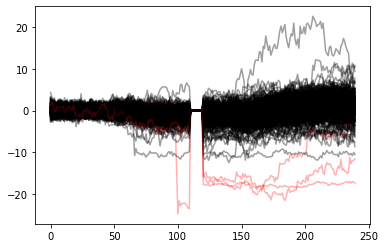

In [77]:
pvh_data = {}
for mouse in PVH_list_of_mice:
    snips, pvh_data[mouse] = get_aucs(PVH, mouse)

In [78]:
filtered_pvh_data = {}

for mouse_id, auc_data in pvh_data.items():
    # Calculate the standard deviation for each AUC metric
    early_threshold = np.std(auc_data['auc_early_licking']) * 3
    late_threshold = np.std(auc_data['auc_late_licking']) * 3
    early_post_threshold = np.std(auc_data['auc_early_post_licking']) * 3
    late_post_threshold = np.std(auc_data['auc_late_post_licking']) * 3

    # Define query strings for filtering each column based on the thresholds
    early_qs = f"auc_early_licking < {early_threshold} and auc_early_licking > {-early_threshold}"
    late_qs = f"auc_late_licking < {late_threshold} and auc_late_licking > {-late_threshold}"
    early_post_qs = f"auc_early_post_licking < {early_post_threshold} and auc_early_post_licking > {-early_post_threshold}"
    late_post_qs = f"auc_late_post_licking < {late_post_threshold} and auc_late_post_licking > {-late_post_threshold}"

    # Combine the query strings to create a single filter
    query_string = f"{early_qs} and {late_qs} and {early_post_qs} and {late_post_qs}"

    # Filter the mouse data based on the combined query string
    filtered_auc_data = auc_data.query(query_string)

    # Add the filtered data to the new dictionary
    filtered_pvh_data[mouse_id] = filtered_auc_data

PVH, restricted
P-values for slopes:
Early AUC vs. Run Length: [0.49702412000179974, 0.06763952552546348, 0.9162335786263444, 0.597895361668648, 0.6279671916872827, 0.23362771228631024, 0.06511932854972657]
Late AUC vs. Run Length: [0.15570694827926912, 0.808254807796252, 0.19315700661207594, 0.014461731504208165, 0.3638193141356958, 0.9458033296011509, 0.7978436181607129]
Early Post AUC vs. Run Length: [0.0032079541814524987, 0.3073553941665517, 0.11692811791262372, 0.20380156339341784, 0.8863759678063936, 0.5145430183538928, 0.872955218408972]
Late Post AUC vs. Run Length: [0.10329875707270221, 0.09800709862594138, 0.06445561853148019, 0.6438238799078924, 0.2871424777488945, 0.7567024834044341, 0.23002122360606617]

One-sample t-test results:
Early Licking: t-statistic = -0.2561607767687477, p-value = 0.8063831732385877
Late Licking: t-statistic = -0.15250694881247756, p-value = 0.8837863832139795
Early Post Licking: t-statistic = -2.152189329869798, p-value = 0.07487965495922663
Lat

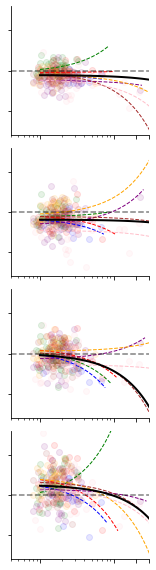

In [79]:
#PVH, restricted

print("PVH, restricted")

def plot_scatter_and_line_of_best_fit(x, y, ax, color, alpha=0.1, label=None):
    # Scatter plot with the color for each mouse
    ax.scatter(x, y, color=color, alpha=alpha, label=label)

    # Fit the model using OLS from statsmodels
    X = sm.add_constant(x)  # Add constant term for intercept
    model = sm.OLS(y, X).fit()  # Fit the model
    slope = model.params[1]  # Get slope
    intercept = model.params[0]  # Get intercept

    # Compute the line of best fit
    xrange = np.linspace(10, ax.get_xlim()[1], 100)
    line = slope * xrange + intercept

    # Plot the line of best fit with a dashed line
    ax.plot(xrange, line, color=color, linestyle='--', linewidth=1)

    # Calculate p-value for the slope
    t_value = model.tvalues[1]  # t-statistic for slope
    p_value = model.pvalues[1]  # p-value for slope

    return slope, intercept, p_value  # Return slope, intercept, and p-value

def plot_mean_line_from_slopes(xrange, mean_slope, mean_intercept, ax, color='black'):
    """Plots a line of best fit using the mean slope and intercept."""
    mean_line = mean_slope * xrange + mean_intercept

    # Plot the mean line in black or any other distinct color
    ax.plot(xrange, mean_line, color=color, linestyle='-', linewidth=2, label='Mean Line')

# Create the figure and subplots
f, ax = plt.subplots(nrows=4, figsize=(2, 8),
                     sharex=True,
                     gridspec_kw={"hspace": 0.1, "wspace": 0.1,
                                  "left": 0.02,
                                  "right": 0.98,
                                  "top": 0.98,
                                  "bottom": 0.02})

# Colors for each mouse
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']

# Data for storing slopes, intercepts, and p-values
slopes_early_licking = []
intercepts_early_licking = []
p_values_early_licking = []
slopes_late_licking = []
intercepts_late_licking = []
p_values_late_licking = []
slopes_early_post_licking = []
intercepts_early_post_licking = []
p_values_early_post_licking = []
slopes_late_post_licking = []
intercepts_late_post_licking = []
p_values_late_post_licking = []

# Iterate over the filtered data for each mouse
for i, (mouse_id, filtered_pvh) in enumerate(filtered_pvh_data.items()):
    color = colors[i % len(colors)]

    # Plot and collect slopes/intercepts and p-values for each metric
    slope, intercept, p_value = plot_scatter_and_line_of_best_fit(filtered_pvh.run_lengths,
                                                                   filtered_pvh.auc_early_licking,
                                                                   ax[0],
                                                                   color,
                                                                   label=mouse_id)
    slopes_early_licking.append(slope)
    intercepts_early_licking.append(intercept)
    p_values_early_licking.append(p_value)

    slope, intercept, p_value = plot_scatter_and_line_of_best_fit(filtered_pvh.run_lengths,
                                                                   filtered_pvh.auc_late_licking,
                                                                   ax[1],
                                                                   color,
                                                                   label=mouse_id)
    slopes_late_licking.append(slope)
    intercepts_late_licking.append(intercept)
    p_values_late_licking.append(p_value)

    slope, intercept, p_value = plot_scatter_and_line_of_best_fit(filtered_pvh.run_lengths,
                                                                   filtered_pvh.auc_early_post_licking,
                                                                   ax[2],
                                                                   color,
                                                                   label=mouse_id)
    slopes_early_post_licking.append(slope)
    intercepts_early_post_licking.append(intercept)
    p_values_early_post_licking.append(p_value)

    slope, intercept, p_value = plot_scatter_and_line_of_best_fit(filtered_pvh.run_lengths,
                                                                   filtered_pvh.auc_late_post_licking,
                                                                   ax[3],
                                                                   color,
                                                                   label=mouse_id)
    slopes_late_post_licking.append(slope)
    intercepts_late_post_licking.append(intercept)
    p_values_late_post_licking.append(p_value)

# Compute mean slope and intercept for each metric
mean_slope_early_licking = np.mean(slopes_early_licking)
mean_intercept_early_licking = np.mean(intercepts_early_licking)

mean_slope_late_licking = np.mean(slopes_late_licking)
mean_intercept_late_licking = np.mean(intercepts_late_licking)

mean_slope_early_post_licking = np.mean(slopes_early_post_licking)
mean_intercept_early_post_licking = np.mean(intercepts_early_post_licking)

mean_slope_late_post_licking = np.mean(slopes_late_post_licking)
mean_intercept_late_post_licking = np.mean(intercepts_late_post_licking)

# Print p-values for each slope
print("P-values for slopes:")
print(f"Early AUC vs. Run Length: {p_values_early_licking}")
print(f"Late AUC vs. Run Length: {p_values_late_licking}")
print(f"Early Post AUC vs. Run Length: {p_values_early_post_licking}")
print(f"Late Post AUC vs. Run Length: {p_values_late_post_licking}")

# One-sample t-test to check if the mean slope is significantly different from zero
t_stat_early_licking, p_val_early_licking = stats.ttest_1samp(slopes_early_licking, 0)
t_stat_late_licking, p_val_late_licking = stats.ttest_1samp(slopes_late_licking, 0)
t_stat_early_post_licking, p_val_early_post_licking = stats.ttest_1samp(slopes_early_post_licking, 0)
t_stat_late_post_licking, p_val_late_post_licking = stats.ttest_1samp(slopes_late_post_licking, 0)

# Print the results of the one-sample t-tests
print("\nOne-sample t-test results:")
print(f"Early Licking: t-statistic = {t_stat_early_licking}, p-value = {p_val_early_licking}")
print(f"Late Licking: t-statistic = {t_stat_late_licking}, p-value = {p_val_late_licking}")
print(f"Early Post Licking: t-statistic = {t_stat_early_post_licking}, p-value = {p_val_early_post_licking}")
print(f"Late Post Licking: t-statistic = {t_stat_late_post_licking}, p-value = {p_val_late_post_licking}")

# Define the shared x-range for the mean lines
xrange = np.linspace(10, ax[0].get_xlim()[1], 100)

# Plot the mean lines for each metric
plot_mean_line_from_slopes(xrange, mean_slope_early_licking, mean_intercept_early_licking, ax[0], color='black')
plot_mean_line_from_slopes(xrange, mean_slope_late_licking, mean_intercept_late_licking, ax[1], color='black')
plot_mean_line_from_slopes(xrange, mean_slope_early_post_licking, mean_intercept_early_post_licking, ax[2], color='black')
plot_mean_line_from_slopes(xrange, mean_slope_late_post_licking, mean_intercept_late_post_licking, ax[3], color='black')

# Customize the appearance of each axis
for axis in ax:
    axis.axhline(0, linestyle="--", color="black", alpha=0.5)
    axis.set_xscale("log")
    axis.set_ylim(-8, 8)
    axis.set_yticklabels([])
    axis.set_xlim(4, 300)
    axis.set_xticks([10, 100, 200, 300])
    axis.set_xticklabels([])

    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)